# Seção 4 - Criando e registrando modelos

## Imports e pre-processamento dos dados

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

Os dados importados e tratados serão utilizados em mais de um modelo.

In [ ]:
credito = pd.read_csv('Credit.csv')
# credito.shape

In [7]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


Transforma as colunas com dados categoricos em numeros. Obs.: Talvez esta não seja a melhor forma de tratamento, porem, foi como o instrutor fez.

In [8]:
for col in credito.columns:
    if credito[col].dtype == 'object':
        credito[col] = credito[col].astype('category').cat.codes

In [9]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [10]:
previsores = credito.iloc[:,0:20].values
classe = credito.iloc[:,20].values

In [11]:
previsores

array([[ 2,  6,  1, ...,  1,  1,  1],
       [ 1, 48,  3, ...,  1,  0,  1],
       [ 0, 12,  1, ...,  2,  0,  1],
       ...,
       [ 0, 12,  3, ...,  1,  0,  1],
       [ 2, 45,  3, ...,  1,  1,  1],
       [ 1, 45,  1, ...,  1,  0,  1]])

In [12]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores,classe,
                                        test_size=0.3,random_state=123)

## Naive Bayes

In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

Algumas funções de plotagem estão obsoletas e serão substituídas por alternativas mais atuais. Por exemplo, plot_confusion_matrix será substituída por sns.heatmap, e plot_roc_curve será substituída por RocCurveDisplay. Essas mudanças garantem compatibilidade com as versões mais recentes das bibliotecas e melhor visualização dos resultados.

In [38]:
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, confusion_matrix

2025/02/06 11:11:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  eb6cc1597717445387ce111f481be32f


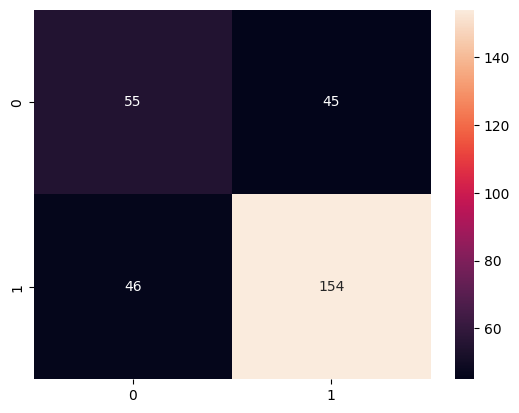

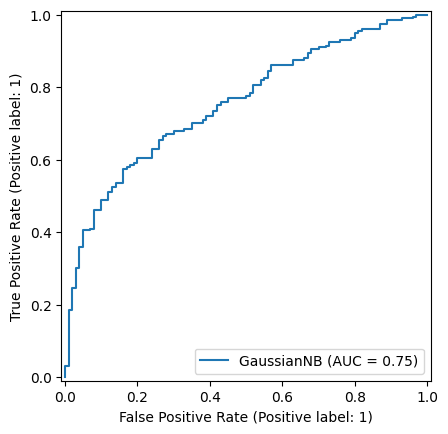

In [ ]:
mlflow.set_experiment("nbexperimento") # cria um experimento no mlflow

with mlflow.start_run():
    naive_bayes = GaussianNB()
    naive_bayes.fit(X_treinamento, y_treinamento)
    previsoes = naive_bayes.predict(X_teste)
    
    # primeiro passo calcular as metricas
    #métricas
    acuracia = accuracy_score(y_teste, previsoes)
    recall = recall_score(y_teste, previsoes)
    precision = precision_score(y_teste, previsoes)
    f1 = f1_score(y_teste, previsoes)
    auc= roc_auc_score(y_teste, previsoes)
    log = log_loss(y_teste, previsoes)
    
    # segundo passo registrar as métricas no mlflow
    #registrar métricas
    mlflow.log_metric("acuracia",acuracia)
    mlflow.log_metric("recall",recall)
    mlflow.log_metric("precision",precision)
    mlflow.log_metric("f1",f1)
    mlflow.log_metric("auc",auc)
    mlflow.log_metric("log",log)
    
   
    # gráficos reformulados 

    matriz = confusion_matrix(y_teste, previsoes) 
    confusion = sns.heatmap((matriz),annot=True, fmt='.0f');
    plt.savefig("confusion.png")
    
    roc = RocCurveDisplay.from_estimator( naive_bayes, X_teste, y_teste)
    plt.savefig("roc.png")

    #logar gráficos
    mlflow.log_artifact("confusion.png")
    mlflow.log_artifact("roc.png")   
    
    #modelo
    mlflow.sklearn.log_model(naive_bayes,"ModeloNB")
    
    
    #informações da execução
    print("Modelo: ", mlflow.active_run().info.run_uuid)    
mlflow.end_run()

## Randonforest

Neste exemplo, foi criada uma função para testar diversas configurações de parâmetros para os modelos. Os modelos testados serão salvos no diretório local e poderão ser consultados via interface do MLflow. Esse processo será repetido para o modelo MLP. Ao final, o diretório do MLflow conterá as execuções dos modelos Naive Bayes, Random Forest e MLP.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

In [ ]:
def treina_rf(n_estimators): # a função foi criada para ser chamada varias vezes o treinamento do modelo com parametros diferentes
    mlflow.set_experiment("rfexperimento")
    mlflow.set_experiment("rfexperimento")
    with mlflow.start_run():

        modelorf = RandomForestClassifier(n_estimators= n_estimators)
        modelorf.fit(X_treinamento, y_treinamento)
        previsoes = modelorf.predict(X_teste)

        #log de hiper parametros
        mlflow.log_param("n_estimators", n_estimators)

        #métricas
        acuracia = accuracy_score(y_teste, previsoes)
        recall = recall_score(y_teste, previsoes)
        precision = precision_score(y_teste, previsoes)
        f1 = f1_score(y_teste, previsoes)
        auc= roc_auc_score(y_teste, previsoes)
        log = log_loss(y_teste, previsoes)
        matriz = confusion_matrix(y_teste, previsoes)

        #registrar métricas
        mlflow.log_metric("acuracia",acuracia)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("f1",f1)
        mlflow.log_metric("auc",auc)
        mlflow.log_metric("log",log)    

        #gráficos
        print("")
        confusion = sns.heatmap((matriz),annot=True, fmt='.0f');
        plt.savefig("confusionrf.png")
        print(" ")   
        roc = RocCurveDisplay.from_estimator(modelorf, X_teste, y_teste)
        plt.savefig("rocfr.png")

        #logar gráficos
        mlflow.log_artifact("confusionrf.png")
        mlflow.log_artifact("rocfr.png")      

        #modelo
        mlflow.sklearn.log_model(modelorf,"ModeloNB")

        #informações da execução
        print("Modelo: ", mlflow.active_run().info.run_uuid)   
    mlflow.end_run()

Após execução observa-se um bug, que esta sobrepondo os gráficos. Porém, não a interferencia nas figuras salvas.

2025/02/06 16:42:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  f7c7f05f7d6043c19190b50a57601d4c


2025/02/06 16:42:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  579950e943614d879aa157eb97d1be75


2025/02/06 16:42:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  8c3bb78aa452460986eb99f0496de06a


2025/02/06 16:42:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  fc7f7473b275494481172e179ca1f809


2025/02/06 16:43:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  d937d111c91a4d25a621066ab997d719


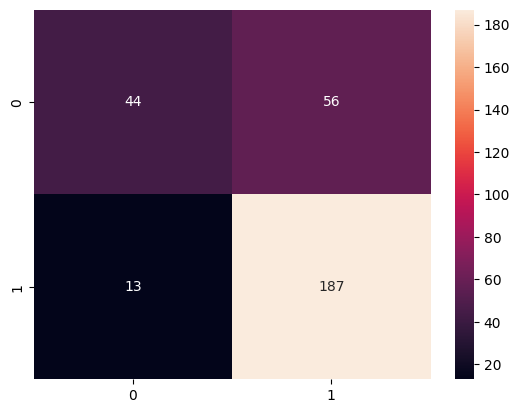

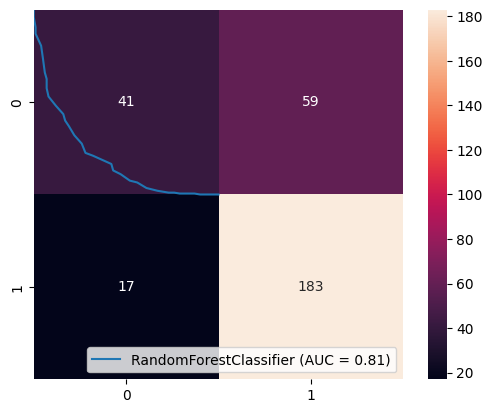

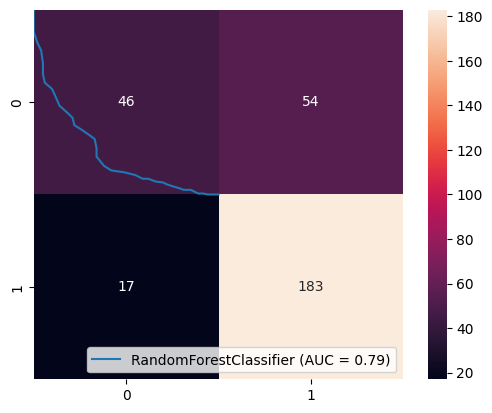

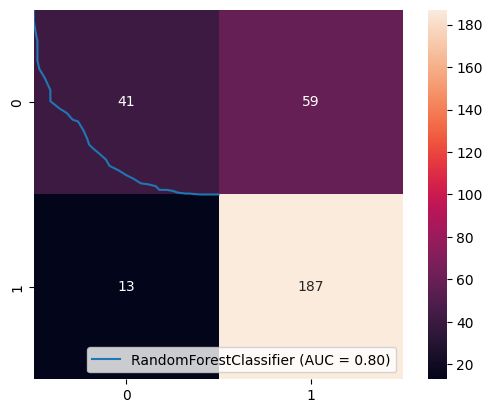

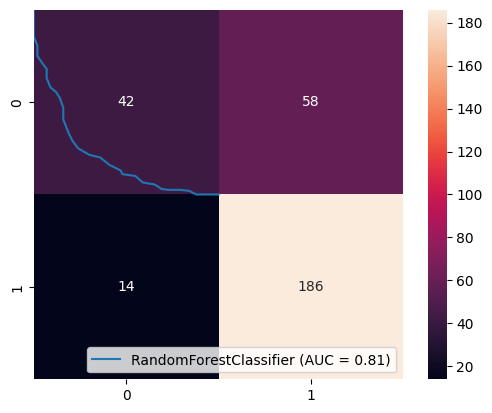

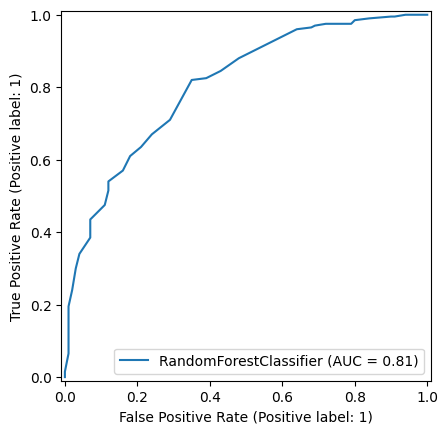

In [62]:
arvores = [50,100,500,750,1000]# 
for n in arvores:
    # print(n)
    treina_rf(n)

## Keras MLP

In [13]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist
import mlflow
import mlflow.tensorflow

Text(0.5, 1.0, '7')

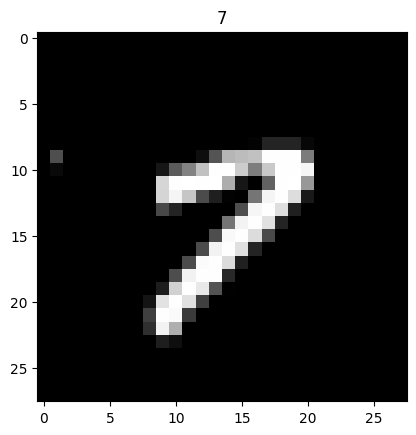

In [14]:
(X_treinamento, y_treinamento),(X_teste, y_teste) = mnist.load_data()
plt.imshow(X_treinamento[29],cmap='gray')
plt.title(y_treinamento[29])

In [15]:
X_treinamento = X_treinamento.reshape((len(X_treinamento), np.prod(X_treinamento.shape[1:])))
X_teste = X_teste.reshape((len(X_teste), np.prod(X_teste.shape[1:])))

In [16]:
X_teste[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [17]:
X_treinamento = X_treinamento.astype('float32')
X_teste = X_teste.astype('float32')
X_treinamento /= 255
X_teste /= 255

In [18]:
y_treinamento = to_categorical(y_treinamento,10)
y_teste = to_categorical(y_teste,10)

In [21]:
y_teste[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [23]:
def treina_dl(n_camadas_ocultas,n_units,activation,drop_out, epochs):
    mlflow.set_experiment("DLExperimento")
    
    with mlflow.start_run():
        mlflow.tensorflow.autolog()
        
        #registro de tags
        mlflow.set_tag("n_camadas_ocultas",n_camadas_ocultas)
        mlflow.set_tag("n_units",n_units)
        mlflow.set_tag("activation",activation)
        mlflow.set_tag("drop_out",drop_out)
        mlflow.set_tag("epochs",epochs)

    
        modelo = Sequential()
        
        #cria camada oculta mais camada de entrada
        modelo.add(Dense(units=n_units, activation=activation, input_dim=784))
        modelo.add(Dropout(drop_out))
        
        #camadas ocultas adicionais, com drop out
        for n in range(n_camadas_ocultas):
            modelo.add(Dense(units=n_units, activation=activation))
            modelo.add(Dropout(drop_out))            
        
        #camada de saída
        modelo.add(Dense(units=10,activation='softmax'))
        
        modelo.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
        
        modelo.summary()
        
        # será adicionado o  hyperaramentro batch_size para o treinamento ir mais rápido
        historico = modelo.fit(X_treinamento, y_treinamento, epochs =epochs, batch_size = 64,
                              validation_data=(X_teste,y_teste))
        
        #grafico para erros e acuracia
        historico.history.keys()
        loss = plt.plot(historico.history['val_loss'])
        plt.savefig("loss.png")
        acuracia = plt.plot(historico.history['val_accuracy'])
        plt.savefig("acuracia.png")
        
        #registrar artefatos
        mlflow.log_artifact("loss.png")
        mlflow.log_artifact("acuracia.png")
       
        #informações de execução
        print("Modelo: ", mlflow.active_run().info.run_uuid)  
    mlflow.end_run()           
        

Houve uma diminuição no número de parametros testado, pois as combinações totalizavam 108 iterações, com as novas configuraçoes de parametros foram reduzidas para

c:\PROGRAMAS\Python3.9\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6082 - loss: 1.1547

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6103 - loss: 1.1491 - val_accuracy: 0.9131 - val_loss: 0.3092
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8615 - loss: 0.4533

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8615 - loss: 0.4533 - val_accuracy: 0.9270 - val_loss: 0.2495
Epoch 3/5
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8799 - loss: 0.3891

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8799 - loss: 0.3891 - val_accuracy: 0.9303 - val_loss: 0.2315
Epoch 4/5
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8904 - loss: 0.3587

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8904 - loss: 0.3587 - val_accuracy: 0.9369 - val_loss: 0.2152
Epoch 5/5
922/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.3376

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3375 - val_accuracy: 0.9372 - val_loss: 0.2092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Modelo:  d8b544a04f274716a922181b188e33c9


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_171 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
913/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6176 - loss: 1.1422

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6214 - loss: 1.1316 - val_accuracy: 0.9100 - val_loss: 0.3168
Epoch 2/15
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.4582

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8570 - loss: 0.4580 - val_accuracy: 0.9240 - val_loss: 0.2593
Epoch 3/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8769 - loss: 0.3952

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8769 - loss: 0.3952 - val_accuracy: 0.9304 - val_loss: 0.2377
Epoch 4/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8883 - loss: 0.3612

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8883 - loss: 0.3612 - val_accuracy: 0.9329 - val_loss: 0.2274
Epoch 5/15
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8977 - loss: 0.3390

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3390 - val_accuracy: 0.9379 - val_loss: 0.2125
Epoch 6/15
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9006 - loss: 0.3194

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3194 - val_accuracy: 0.9377 - val_loss: 0.2092
Epoch 7/15
923/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9059 - loss: 0.3089

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9059 - loss: 0.3089 - val_accuracy: 0.9407 - val_loss: 0.1987
Epoch 8/15
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9088 - loss: 0.2963

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9088 - loss: 0.2963 - val_accuracy: 0.9409 - val_loss: 0.1973
Epoch 9/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9130 - loss: 0.2866

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9130 - loss: 0.2866 - val_accuracy: 0.9457 - val_loss: 0.1921
Epoch 10/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9139 - loss: 0.2837

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9139 - loss: 0.2837 - val_accuracy: 0.9450 - val_loss: 0.1908
Epoch 11/15
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9161 - loss: 0.2721

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9161 - loss: 0.2721 - val_accuracy: 0.9457 - val_loss: 0.1865
Epoch 12/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9177 - loss: 0.2694

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9177 - loss: 0.2694 - val_accuracy: 0.9464 - val_loss: 0.1842
Epoch 13/15
923/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2643

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9196 - loss: 0.2644 - val_accuracy: 0.9466 - val_loss: 0.1804
Epoch 14/15
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9186 - loss: 0.2608

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9186 - loss: 0.2608 - val_accuracy: 0.9477 - val_loss: 0.1803
Epoch 15/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9239 - loss: 0.2491 - val_accuracy: 0.9472 - val_loss: 0.1847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  f69711d985c84550b7978d58fa86ed98


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_174 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7158 - loss: 0.8868

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7168 - loss: 0.8838 - val_accuracy: 0.9337 - val_loss: 0.2251
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9095 - loss: 0.2989

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9096 - loss: 0.2989 - val_accuracy: 0.9487 - val_loss: 0.1701
Epoch 3/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9275 - loss: 0.2385

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9276 - loss: 0.2384 - val_accuracy: 0.9541 - val_loss: 0.1484
Epoch 4/5
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9393 - loss: 0.1978

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9393 - loss: 0.1978 - val_accuracy: 0.9576 - val_loss: 0.1377
Epoch 5/5
926/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9455 - loss: 0.1838

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9455 - loss: 0.1838 - val_accuracy: 0.9620 - val_loss: 0.1275
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Modelo:  e76b010439ed463f9ad0390bef40dd34


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_177 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7389 - loss: 0.8421

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7400 - loss: 0.8386 - val_accuracy: 0.9390 - val_loss: 0.2115
Epoch 2/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9214 - loss: 0.2700

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9214 - loss: 0.2699 - val_accuracy: 0.9520 - val_loss: 0.1652
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9339 - loss: 0.2239

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9339 - loss: 0.2239 - val_accuracy: 0.9571 - val_loss: 0.1445
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9427 - loss: 0.1886

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9427 - loss: 0.1886 - val_accuracy: 0.9603 - val_loss: 0.1303
Epoch 5/15
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9467 - loss: 0.1764

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9467 - loss: 0.1763 - val_accuracy: 0.9630 - val_loss: 0.1213
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9506 - loss: 0.1624 - val_accuracy: 0.9629 - val_loss: 0.1214
Epoch 7/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9528 - loss: 0.1535

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9528 - loss: 0.1535 - val_accuracy: 0.9658 - val_loss: 0.1136
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9553 - loss: 0.1450 - val_accuracy: 0.9655 - val_loss: 0.1139
Epoch 9/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9573 - loss: 0.1381 - val_accuracy: 0.9671 - val_loss: 0.1176
Epoch 10/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9598 - loss: 0.1292 - val_accuracy: 0.9655 - val_loss: 0.1152
Epoch 11/15
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9596 - loss: 0.1293

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9596 - loss: 0.1294 - val_accuracy: 0.9680 - val_loss: 0.1097
Epoch 12/15
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9647 - loss: 0.1170

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9647 - loss: 0.1170 - val_accuracy: 0.9682 - val_loss: 0.1090
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9631 - loss: 0.1160 - val_accuracy: 0.9675 - val_loss: 0.1140
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9629 - loss: 0.1194 - val_accuracy: 0.9677 - val_loss: 0.1113
Epoch 15/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9647 - loss: 0.1112 - val_accuracy: 0.9674 - val_loss: 0.1129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Modelo:  4ff6db0165e54c978920376b5d79402f


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7797 - loss: 0.7243

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7808 - loss: 0.7210 - val_accuracy: 0.9495 - val_loss: 0.1663
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9425 - loss: 0.1914

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9425 - loss: 0.1914 - val_accuracy: 0.9638 - val_loss: 0.1182
Epoch 3/5
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9544 - loss: 0.1485

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9544 - loss: 0.1485 - val_accuracy: 0.9651 - val_loss: 0.1135
Epoch 4/5
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9655 - loss: 0.1158

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9655 - loss: 0.1158 - val_accuracy: 0.9739 - val_loss: 0.0890
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.1008

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9693 - loss: 0.1008 - val_accuracy: 0.9739 - val_loss: 0.0846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Modelo:  7f688abde9114c428dbdda857c616474


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_183 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7945 - loss: 0.6702

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7946 - loss: 0.6699 - val_accuracy: 0.9479 - val_loss: 0.1701
Epoch 2/15
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9411 - loss: 0.1979

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9411 - loss: 0.1978 - val_accuracy: 0.9603 - val_loss: 0.1257
Epoch 3/15
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9536 - loss: 0.1507

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9537 - loss: 0.1507 - val_accuracy: 0.9665 - val_loss: 0.1052
Epoch 4/15
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9608 - loss: 0.1254

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9608 - loss: 0.1254 - val_accuracy: 0.9685 - val_loss: 0.0981
Epoch 5/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9660 - loss: 0.1078

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9660 - loss: 0.1078 - val_accuracy: 0.9691 - val_loss: 0.0915
Epoch 6/15
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9707 - loss: 0.0918

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9707 - loss: 0.0919 - val_accuracy: 0.9721 - val_loss: 0.0860
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9736 - loss: 0.0834

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9736 - loss: 0.0834 - val_accuracy: 0.9744 - val_loss: 0.0848
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9773 - loss: 0.0742 - val_accuracy: 0.9736 - val_loss: 0.0856
Epoch 9/15
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9759 - loss: 0.0734

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9759 - loss: 0.0734 - val_accuracy: 0.9778 - val_loss: 0.0753
Epoch 10/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9787 - loss: 0.0668 - val_accuracy: 0.9751 - val_loss: 0.0813
Epoch 11/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9789 - loss: 0.0662 - val_accuracy: 0.9766 - val_loss: 0.0758
Epoch 12/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9797 - loss: 0.0607 - val_accuracy: 0.9756 - val_loss: 0.0799
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9811 - loss: 0.0573 - val_accuracy: 0.9774 - val_loss: 0.0805
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9839 - loss: 0.0510 - val_accuracy: 0.9770 - val_loss: 0.0795
Epoch 15/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9845 - loss: 0.0497 - val_accuracy: 0.9770 - val_loss: 0.0811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Modelo:  b6d3a7956d094e72bc21e2cb2b3e2ddf


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_186 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
923/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5185 - loss: 1.3712

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5212 - loss: 1.3643 - val_accuracy: 0.8990 - val_loss: 0.3554
Epoch 2/5
927/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8247 - loss: 0.5627

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8248 - loss: 0.5624 - val_accuracy: 0.9199 - val_loss: 0.2763
Epoch 3/5
924/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 0.4730

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8564 - loss: 0.4729 - val_accuracy: 0.9231 - val_loss: 0.2524
Epoch 4/5
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - loss: 0.4210

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8722 - loss: 0.4209 - val_accuracy: 0.9283 - val_loss: 0.2401
Epoch 5/5
911/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8776 - loss: 0.3979

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8777 - loss: 0.3977 - val_accuracy: 0.9329 - val_loss: 0.2256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Modelo:  bac877bb3e404a38b0e34d532ada2bb9


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_190 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5599 - loss: 1.2572

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5600 - loss: 1.2568 - val_accuracy: 0.8958 - val_loss: 0.3745
Epoch 2/15
917/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8231 - loss: 0.5686

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8233 - loss: 0.5681 - val_accuracy: 0.9135 - val_loss: 0.2993
Epoch 3/15
918/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.4920

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8503 - loss: 0.4916 - val_accuracy: 0.9221 - val_loss: 0.2702
Epoch 4/15
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - loss: 0.4411

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8681 - loss: 0.4410 - val_accuracy: 0.9249 - val_loss: 0.2594
Epoch 5/15
919/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 0.4155

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8771 - loss: 0.4153 - val_accuracy: 0.9281 - val_loss: 0.2462
Epoch 6/15
926/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8876 - loss: 0.3849

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8876 - loss: 0.3849 - val_accuracy: 0.9313 - val_loss: 0.2326
Epoch 7/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8913 - loss: 0.3748

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8913 - loss: 0.3748 - val_accuracy: 0.9370 - val_loss: 0.2257
Epoch 8/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.3555

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3555 - val_accuracy: 0.9358 - val_loss: 0.2242
Epoch 9/15
920/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8997 - loss: 0.3391

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3392 - val_accuracy: 0.9393 - val_loss: 0.2187
Epoch 10/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.3393 - val_accuracy: 0.9362 - val_loss: 0.2250
Epoch 11/15
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8999 - loss: 0.3391

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3391 - val_accuracy: 0.9398 - val_loss: 0.2173
Epoch 12/15
922/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9060 - loss: 0.3271

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9060 - loss: 0.3271 - val_accuracy: 0.9398 - val_loss: 0.2161
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9057 - loss: 0.3228 - val_accuracy: 0.9380 - val_loss: 0.2206
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9079 - loss: 0.3190 - val_accuracy: 0.9385 - val_loss: 0.2240
Epoch 15/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9099 - loss: 0.3101 - val_accuracy: 0.9398 - val_loss: 0.2161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Modelo:  00f45d9970284568a4aa0cc300f896a5


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_194 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6969 - loss: 0.9215

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6974 - loss: 0.9200 - val_accuracy: 0.9337 - val_loss: 0.2184
Epoch 2/5
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9068 - loss: 0.3120

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9069 - loss: 0.3118 - val_accuracy: 0.9475 - val_loss: 0.1723
Epoch 3/5
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9277 - loss: 0.2469

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9277 - loss: 0.2469 - val_accuracy: 0.9551 - val_loss: 0.1536
Epoch 4/5
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9358 - loss: 0.2193

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9358 - loss: 0.2193 - val_accuracy: 0.9575 - val_loss: 0.1417
Epoch 5/5
924/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9411 - loss: 0.2012

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9411 - loss: 0.2012 - val_accuracy: 0.9600 - val_loss: 0.1337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Modelo:  21308b2717de444e91164a4c4a861198


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_198 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6751 - loss: 0.9901

938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6766 - loss: 0.9860 - val_accuracy: 0.9296 - val_loss: 0.2323
Epoch 2/15
923/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9055 - loss: 0.3200

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9056 - loss: 0.3197 - val_accuracy: 0.9494 - val_loss: 0.1726
Epoch 3/15
917/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9260 - loss: 0.2495

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9260 - loss: 0.2493 - val_accuracy: 0.9526 - val_loss: 0.1565
Epoch 4/15
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9334 - loss: 0.2242

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9334 - loss: 0.2241 - val_accuracy: 0.9593 - val_loss: 0.1371
Epoch 5/15
924/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9408 - loss: 0.2038

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9408 - loss: 0.2037 - val_accuracy: 0.9626 - val_loss: 0.1253
Epoch 6/15
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9445 - loss: 0.1836

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9445 - loss: 0.1836 - val_accuracy: 0.9626 - val_loss: 0.1239
Epoch 7/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9485 - loss: 0.1721

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9485 - loss: 0.1721 - val_accuracy: 0.9645 - val_loss: 0.1213
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9506 - loss: 0.1654 - val_accuracy: 0.9643 - val_loss: 0.1254
Epoch 9/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9532 - loss: 0.1559 - val_accuracy: 0.9651 - val_loss: 0.1220
Epoch 10/15
923/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9570 - loss: 0.1456

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9569 - loss: 0.1458 - val_accuracy: 0.9664 - val_loss: 0.1182
Epoch 11/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9540 - loss: 0.1516 - val_accuracy: 0.9669 - val_loss: 0.1194
Epoch 12/15
917/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9586 - loss: 0.1379

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9586 - loss: 0.1380 - val_accuracy: 0.9675 - val_loss: 0.1129
Epoch 13/15
927/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9588 - loss: 0.1329

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9588 - loss: 0.1329 - val_accuracy: 0.9668 - val_loss: 0.1118
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9590 - loss: 0.1324 - val_accuracy: 0.9667 - val_loss: 0.1193
Epoch 15/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9609 - loss: 0.1280 - val_accuracy: 0.9671 - val_loss: 0.1166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Modelo:  b6121bf7d90b4360a22157f73b09f2de


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_202 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7684 - loss: 0.7252

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7688 - loss: 0.7242 - val_accuracy: 0.9511 - val_loss: 0.1666
Epoch 2/5
926/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9376 - loss: 0.2052

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9376 - loss: 0.2050 - val_accuracy: 0.9628 - val_loss: 0.1202
Epoch 3/5
924/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1530

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9535 - loss: 0.1530 - val_accuracy: 0.9665 - val_loss: 0.1052
Epoch 4/5
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9618 - loss: 0.1243

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9618 - loss: 0.1244 - val_accuracy: 0.9721 - val_loss: 0.0955
Epoch 5/5
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9672 - loss: 0.1098

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9672 - loss: 0.1098 - val_accuracy: 0.9710 - val_loss: 0.0947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Modelo:  1891a77029eb4f90b71ecef9a31bee9f


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_206 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.7291

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7723 - loss: 0.7284 - val_accuracy: 0.9533 - val_loss: 0.1575
Epoch 2/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9420 - loss: 0.1921

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9420 - loss: 0.1921 - val_accuracy: 0.9623 - val_loss: 0.1250
Epoch 3/15
924/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9574 - loss: 0.1397

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9574 - loss: 0.1397 - val_accuracy: 0.9661 - val_loss: 0.1096
Epoch 4/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9648 - loss: 0.1182

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9647 - loss: 0.1182 - val_accuracy: 0.9730 - val_loss: 0.0907
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9666 - loss: 0.1086 - val_accuracy: 0.9726 - val_loss: 0.0923
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9708 - loss: 0.0962 - val_accuracy: 0.9725 - val_loss: 0.0945
Epoch 7/15
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9725 - loss: 0.0901

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9725 - loss: 0.0901 - val_accuracy: 0.9764 - val_loss: 0.0837
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9744 - loss: 0.0823 - val_accuracy: 0.9733 - val_loss: 0.0896
Epoch 9/15
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9747 - loss: 0.0809

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9747 - loss: 0.0810 - val_accuracy: 0.9754 - val_loss: 0.0826
Epoch 10/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9777 - loss: 0.0730 - val_accuracy: 0.9757 - val_loss: 0.0864
Epoch 11/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 0.0666

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9788 - loss: 0.0666 - val_accuracy: 0.9777 - val_loss: 0.0809
Epoch 12/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9806 - loss: 0.0628 - val_accuracy: 0.9763 - val_loss: 0.0843
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9801 - loss: 0.0644 - val_accuracy: 0.9751 - val_loss: 0.0828
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9813 - loss: 0.0590 - val_accuracy: 0.9770 - val_loss: 0.0818
Epoch 15/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9829 - loss: 0.0554 - val_accuracy: 0.9781 - val_loss: 0.0841
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Modelo:  1315faa019584afb98db2e67547fc655


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4532 - loss: 1.5022

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4537 - loss: 1.5010 - val_accuracy: 0.8867 - val_loss: 0.4548
Epoch 2/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7928 - loss: 0.6573

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7929 - loss: 0.6572 - val_accuracy: 0.9132 - val_loss: 0.3203
Epoch 3/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 0.5286

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8423 - loss: 0.5285 - val_accuracy: 0.9216 - val_loss: 0.2907
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.5013

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8531 - loss: 0.5013 - val_accuracy: 0.9222 - val_loss: 0.2725
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8675 - loss: 0.4673 - val_accuracy: 0.9241 - val_loss: 0.2731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Modelo:  08ca274207544dfdaa0f3caf2c795c91


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_215 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4785 - loss: 1.4319

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4792 - loss: 1.4302 - val_accuracy: 0.8998 - val_loss: 0.3688
Epoch 2/15
927/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8102 - loss: 0.6065

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8104 - loss: 0.6061 - val_accuracy: 0.9186 - val_loss: 0.2960
Epoch 3/15
927/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8499 - loss: 0.4956

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8500 - loss: 0.4955 - val_accuracy: 0.9225 - val_loss: 0.2725
Epoch 4/15
923/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.4562

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8668 - loss: 0.4560 - val_accuracy: 0.9296 - val_loss: 0.2538
Epoch 5/15
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8780 - loss: 0.4164

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8781 - loss: 0.4164 - val_accuracy: 0.9311 - val_loss: 0.2418
Epoch 6/15
918/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8830 - loss: 0.4029

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8831 - loss: 0.4027 - val_accuracy: 0.9345 - val_loss: 0.2357
Epoch 7/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8880 - loss: 0.3871

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8880 - loss: 0.3870 - val_accuracy: 0.9395 - val_loss: 0.2214
Epoch 8/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - loss: 0.3704

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8940 - loss: 0.3704 - val_accuracy: 0.9404 - val_loss: 0.2211
Epoch 9/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8977 - loss: 0.3580 - val_accuracy: 0.9396 - val_loss: 0.2258
Epoch 10/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9000 - loss: 0.3556

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9000 - loss: 0.3556 - val_accuracy: 0.9408 - val_loss: 0.2186
Epoch 11/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9027 - loss: 0.3407

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9027 - loss: 0.3407 - val_accuracy: 0.9427 - val_loss: 0.2033
Epoch 12/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9046 - loss: 0.3352 - val_accuracy: 0.9428 - val_loss: 0.2096
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9071 - loss: 0.3283 - val_accuracy: 0.9432 - val_loss: 0.2060
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9103 - loss: 0.3164 - val_accuracy: 0.9465 - val_loss: 0.2060
Epoch 15/15
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9127 - loss: 0.3112

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9127 - loss: 0.3112 - val_accuracy: 0.9470 - val_loss: 0.2027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Modelo:  c8b3d04cf7224ff09d3d7d8c9ec16e85


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6478 - loss: 1.0587

938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6480 - loss: 1.0583 - val_accuracy: 0.9253 - val_loss: 0.2563
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8970 - loss: 0.3510

938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8970 - loss: 0.3510 - val_accuracy: 0.9414 - val_loss: 0.1982
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9193 - loss: 0.2828

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9193 - loss: 0.2828 - val_accuracy: 0.9472 - val_loss: 0.1781
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9314 - loss: 0.2446

938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9314 - loss: 0.2446 - val_accuracy: 0.9547 - val_loss: 0.1555
Epoch 5/5
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9363 - loss: 0.2211

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9363 - loss: 0.2211 - val_accuracy: 0.9561 - val_loss: 0.1528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Modelo:  1f61002525b3498abf213837e13337b1


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_225 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6398 - loss: 1.0659

938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6413 - loss: 1.0620 - val_accuracy: 0.9316 - val_loss: 0.2301
Epoch 2/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9078 - loss: 0.3289

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9078 - loss: 0.3287 - val_accuracy: 0.9495 - val_loss: 0.1763
Epoch 3/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9261 - loss: 0.2594

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9261 - loss: 0.2594 - val_accuracy: 0.9511 - val_loss: 0.1690
Epoch 4/15
924/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9358 - loss: 0.2271

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9358 - loss: 0.2271 - val_accuracy: 0.9567 - val_loss: 0.1545
Epoch 5/15
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9417 - loss: 0.2104

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9417 - loss: 0.2104 - val_accuracy: 0.9560 - val_loss: 0.1515
Epoch 6/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9471 - loss: 0.1891

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9471 - loss: 0.1891 - val_accuracy: 0.9599 - val_loss: 0.1420
Epoch 7/15
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9485 - loss: 0.1822

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9485 - loss: 0.1822 - val_accuracy: 0.9626 - val_loss: 0.1355
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9507 - loss: 0.1725 - val_accuracy: 0.9606 - val_loss: 0.1483
Epoch 9/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9533 - loss: 0.1622 - val_accuracy: 0.9624 - val_loss: 0.1398
Epoch 10/15
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9534 - loss: 0.1660

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9534 - loss: 0.1660 - val_accuracy: 0.9654 - val_loss: 0.1315
Epoch 11/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9564 - loss: 0.1557 - val_accuracy: 0.9641 - val_loss: 0.1374
Epoch 12/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9567 - loss: 0.1526 - val_accuracy: 0.9634 - val_loss: 0.1371
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9590 - loss: 0.1427 - val_accuracy: 0.9625 - val_loss: 0.1429
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9578 - loss: 0.1460 - val_accuracy: 0.9654 - val_loss: 0.1356
Epoch 15/15
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9584 - loss: 0.1424

938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9584 - loss: 0.1424 - val_accuracy: 0.9643 - val_loss: 0.1285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Modelo:  3990b6502c844747bd557219a9efd856


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_230 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7424 - loss: 0.7992

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7428 - loss: 0.7981 - val_accuracy: 0.9512 - val_loss: 0.1639
Epoch 2/5
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9383 - loss: 0.2133

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9383 - loss: 0.2133 - val_accuracy: 0.9599 - val_loss: 0.1318
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9541 - loss: 0.1579

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9541 - loss: 0.1579 - val_accuracy: 0.9640 - val_loss: 0.1176
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9602 - loss: 0.1376 - val_accuracy: 0.9645 - val_loss: 0.1199
Epoch 5/5
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9653 - loss: 0.1161

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9653 - loss: 0.1161 - val_accuracy: 0.9706 - val_loss: 0.0961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Modelo:  80317ebf71d54f16b3aa59cd7f98656e


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_235 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7546 - loss: 0.7733

938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7547 - loss: 0.7729 - val_accuracy: 0.9537 - val_loss: 0.1545
Epoch 2/15
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9390 - loss: 0.2081

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9390 - loss: 0.2080 - val_accuracy: 0.9633 - val_loss: 0.1210
Epoch 3/15
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9536 - loss: 0.1591

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9537 - loss: 0.1591 - val_accuracy: 0.9671 - val_loss: 0.1103
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9618 - loss: 0.1319

938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9618 - loss: 0.1319 - val_accuracy: 0.9704 - val_loss: 0.0972
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9653 - loss: 0.1185 - val_accuracy: 0.9694 - val_loss: 0.1015
Epoch 6/15
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9687 - loss: 0.1057

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9687 - loss: 0.1057 - val_accuracy: 0.9744 - val_loss: 0.0886
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9696 - loss: 0.1006 - val_accuracy: 0.9719 - val_loss: 0.0939
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9725 - loss: 0.0903 - val_accuracy: 0.9730 - val_loss: 0.0939
Epoch 9/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9749 - loss: 0.0823

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9749 - loss: 0.0823 - val_accuracy: 0.9764 - val_loss: 0.0814
Epoch 10/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9764 - loss: 0.0793 - val_accuracy: 0.9761 - val_loss: 0.0847
Epoch 11/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9778 - loss: 0.0721 - val_accuracy: 0.9769 - val_loss: 0.0843
Epoch 12/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9781 - loss: 0.0697 - val_accuracy: 0.9763 - val_loss: 0.0867
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9792 - loss: 0.0665 - val_accuracy: 0.9781 - val_loss: 0.0857
Epoch 14/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9809 - loss: 0.0623 - val_accuracy: 0.9757 - val_loss: 0.0856
Epoch 15/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9807 - loss: 0.0630 - val_accuracy: 0.9780 - val_loss: 0.0848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Modelo:  75279754dc954bf6b9efe237a805c9df


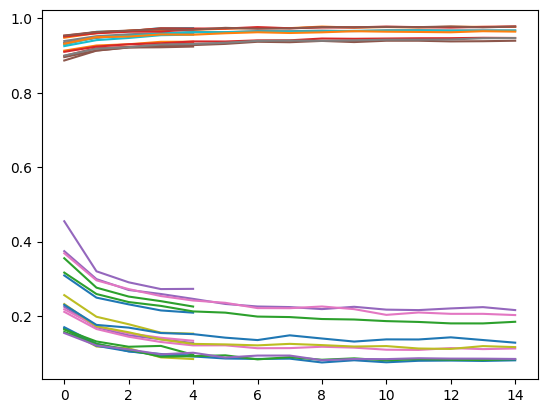

In [25]:
# n_camadas_ocultas = [1,2,3]
# n_units = [16,32,64]
# activation = ['relu','tanh']
# drop_out = [0.1, 0.2]
# epochs = [5,10,20]

# Como  o exemplo estava travando, foi feito um teste com menos parametros  
n_camadas_ocultas = [1,2,3]
n_units = [16,32,64]
activation = ['relu']
drop_out = [0.1]
epochs = [5,15]

for camadas in n_camadas_ocultas:
    for unidades in n_units:
        for ativacao in activation:
            for drop in drop_out:
                for epocas in epochs:
                    treina_dl(camadas,unidades,ativacao, drop, epocas)

***Importante***

Como a última seção de deploy está apresentando erros, muito provavelmente devido a incompatibilidade de versão, ela não foi executada, e o código permanece comentado. Não será feito downgrade de versão, pois isso poderia comprometer todas as execuções anteriores, e optei por não correr esse risco. Dessa forma, apenas acompanhei as aulas sem realizar a execução prática dessa parte.

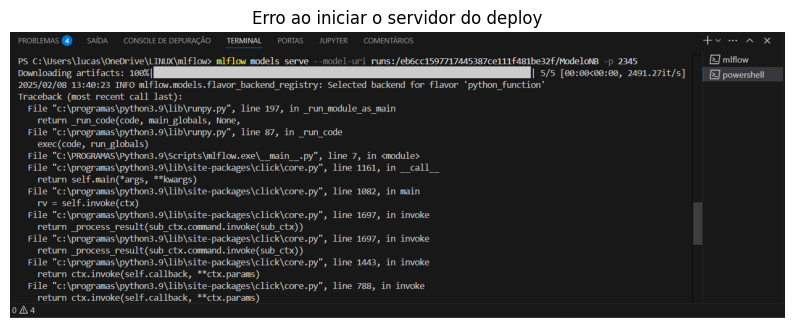

In [30]:
import matplotlib.pyplot as plt

# Se você tiver uma imagem em um arquivo, você pode usar plt.imread para lê-la
img_erro = plt.imread('img_erro.png')  # Substitua pelo caminho do seu arquivo de imagem

plt.figure(figsize=(10, 10))
plt.imshow(img_erro)
plt.axis('off') 
plt.title('Erro ao iniciar o servidor do deploy')
plt.show()


## Servindo 

In [ ]:
# import requests
# import pandas as pd

In [ ]:
# credito = pd.read_csv("Credit.csv")

In [ ]:
# for col in credito.columns:
#     if credito[col].dtype == 'object':
#         credito[col] = credito[col].astype('category').cat.codes

In [ ]:
# dados = credito.iloc[0:10,0:20].to_json(orient='split')

In [ ]:
# dados

In [ ]:
# previsao = requests.post(url='http://localhost:2345/invocations', 
#                          headers={'Content-Type' : 'application/json' , }, data=dados)

In [ ]:
# previsao

In [ ]:
# previsao.text